# CUSTOMER LIFETIME VALUE

## The aim of this notebook is to determine the customer life time value. It is an important statistic since retaining existing customers costs less than acquiring new ones. Thus, improving the value of your existing customers is a great strategy to generate growth.

# Importing all the required libraries

In [244]:
pip install lifetimes


Note: you may need to restart the kernel to use updated packages.


In [245]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [246]:
%pylab inline

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import plotly
import plotly.offline as pyoff
import plotly.graph_objs as go

np.random.seed(42)
import random
random.seed(42)
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta
from datetime import datetime
import gc
import itertools

import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.plotting import *
from lifetimes.utils import *
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff


Populating the interactive namespace from numpy and matplotlib


In [247]:
def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

# Loading the datasets

In [248]:
customers_db = pd.read_csv("/Users/tejaltandel/archive/olist_customers_dataset.csv")
geolocation_db = pd.read_csv("/Users/tejaltandel/archive/olist_geolocation_dataset.csv")
order_items_db = pd.read_csv("/Users/tejaltandel/archive/olist_order_items_dataset.csv")
order_payments_db = pd.read_csv("/Users/tejaltandel/archive/olist_order_payments_dataset.csv")
product_reviews_db = pd.read_csv("/Users/tejaltandel/archive/olist_order_reviews_dataset.csv")
orders_db = pd.read_csv("/Users/tejaltandel/archive/olist_orders_dataset.csv")
products_db = pd.read_csv("/Users/tejaltandel/archive/olist_products_dataset.csv")
sellers_db = pd.read_csv("/Users/tejaltandel/archive/olist_sellers_dataset.csv")
category_db = pd.read_csv("/Users/tejaltandel/archive/product_category_name_translation.csv")

#### Displaying data shape and column headings

In [249]:

dataset = {
    'Customers': customers_db,
    'Order Items': order_items_db,
    'Payments': order_payments_db,
    'Orders': orders_db,
    'Products': products_db,
    'Sellers': sellers_db
}

for x, y in dataset.items():
    print(f'{x}', (list(y.shape)))
    print(f'{x}', f'{list(y.columns)}')
    print('\n')

Customers [99441, 7]
Customers ['customer_state', 'customer_id2', 'uniqueid_2', 'customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city']


Order Items [112650, 7]
Order Items ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']


Payments [103886, 5]
Payments ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']


Orders [99441, 9]
Orders ['order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_id2', 'order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at']


Products [32951, 10]
Products ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'productid_2']


Sellers [3095, 5]
Sellers ['seller_zip_code_prefix', 'seller_city', 'seller_state', 'sellerid

In [250]:
orders_db[['customer_id']]

,customer_id
0,9ef432eb6251297304e76186b10a928d
1,b0830fb4747a6c6d20dea0b8c802d7ef
2,41ce2a54c0b03bf3443c3d931a367089
3,f88197465ea7920adcdbec7375364d82
4,8ab97904e6daea8866dbdbc4fb7aad2c
...,...
99436,39bd1228ee8140590ac3aca26f2dfe00
99437,1fca14ff2861355f6e5f14306ff977a7
99438,1aa71eb042121263aafbe80c1b562c9c
99439,b331b74b18dc79bcdf6532d51e1637c1


In [251]:
cols = ['customer_id', 'order_id', 'order_purchase_timestamp']
orders_db = orders_db[cols]
orders_db = orders_db.set_index('customer_id')
orders_db.drop_duplicates(inplace=True)
orders_db["order_purchase_timestamp"] = pd.to_datetime(orders_db["order_purchase_timestamp"])
cols = ['customer_id', 'customer_unique_id']
customers_db = customers_db[cols]
customers_db = customers_db.set_index('customer_id')

# concatinating Datasets
purchases_db = pd.concat([orders_db,customers_db], axis=1, join='inner')
purchases_db.reset_index(inplace=True)
purchases_db.head(5)
cols = ['customer_unique_id', 'order_id','order_purchase_timestamp']
purchases_db = purchases_db[cols]

In [252]:
customers_db

,customer_unique_id
customer_id,
06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0
18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3
4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e
b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c
4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066
...,...
17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8
e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d
5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99


In [253]:
# aggregate cost of items
costs = order_items_db.groupby("order_id")["price"].sum()

# adding columns and conversion to datetime
purchases_db['order_purchase_timestamp'] = pd.to_datetime(purchases_db['order_purchase_timestamp'])
purchases_db['order_date'] = purchases_db.order_purchase_timestamp.dt.date
purchases_db['order_date'] = pd.to_datetime(purchases_db['order_date'])
cols = ['customer_unique_id', 'order_id', 'order_date']
purchases_db = purchases_db[cols]
purchases_db.head(5)

,customer_unique_id,order_id,order_date
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13


In [254]:
purchases_db = purchases_db.merge(costs.to_frame("total_cost").reset_index(), on='order_id')
purchases_db.columns = ["customer_id", "order_id", "order_date", "total_cost"]

# Active Customers

In [255]:
#Counting unique Customer IDs to make active customers dataframe (by month)
customer_order_db = pd.concat([orders_db,customers_db], axis=1, join='inner')
customer_order_db = customer_order_db.merge(order_payments_db, on='order_id')
customer_order_db['order_purchase_month'] = customer_order_db.order_purchase_timestamp.apply(lambda x: x.month)
customer_order_db['order_purchase_year'] = customer_order_db.order_purchase_timestamp.apply(lambda x: x.year)
customer_order_db['month_year'] = customer_order_db['order_purchase_year'].astype(str)\
+ '-' + customer_order_db['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
customer_order_db['month_y'] = customer_order_db['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

customer_order_db.head(5)
monthly_active_users = customer_order_db.groupby('month_year')['customer_unique_id'].nunique().reset_index()

In [256]:
monthly_active_users

,month_year,customer_unique_id
0,2016-09,3
1,2016-10,321
2,2016-12,1
3,2017-01,765
4,2017-02,1755
5,2017-03,2642
6,2017-04,2372
7,2017-05,3625
8,2017-06,3180
9,2017-07,3947


In [257]:
monthly_active_users.to_csv('/Users/tejaltandel/archive/monthly_active_users.csv')

In [258]:
configure_plotly_browser_state()
trace0 = go.Bar(
    x=monthly_active_users["month_year"].values,
    y=monthly_active_users["customer_unique_id"].values,
    marker=dict(
        color=['rgba(36,123,160,1)', 
               'rgba(75,147,177,1)',
               'rgba(112,193,179,1)', 
               'rgba(138,204,192,1)',
               'rgba(243,255,189,1)',
               'rgba(247,255,213,1)',
               'rgba(255,22,84,1)']),
)

data = [trace0]

layout = go.Layout(
    title='Active Customers',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

# New vs Existing Customers

In [259]:
#create a dataframe contaning CustomerID and first purchase date
df_min_purchase = customer_order_db.groupby('customer_unique_id').order_purchase_timestamp.min().reset_index()
df_min_purchase.columns = ['customer_unique_id','minpurchasedate']
df_min_purchase['minpurchasedate'] = df_min_purchase['minpurchasedate'].map(lambda date: 100*date.year + date.month)

#merge first purchase date column to our main dataframe (tx_uk)
customer_order_db = pd.merge(customer_order_db, df_min_purchase, on='customer_unique_id')
#create a column called User Type and assign Existing 
#if User's First Purchase Year Month before the selected Invoice Year Month
customer_order_db['usertype'] = 'New'
customer_order_db.loc[customer_order_db['month_y']>customer_order_db['minpurchasedate'],'usertype'] = 'Existing'

#calculate the Revenue per month for each user type
df_user_type_revenue = customer_order_db.groupby(['month_y','usertype', 'month_year'])['payment_value'].sum().reset_index()

df_user_type_revenue

,month_y,usertype,month_year,payment_value
0,201609,New,2016-09,252.24
1,201610,New,2016-10,59090.48
2,201612,New,2016-12,19.62
3,201701,Existing,2017-01,19.62
4,201701,New,2017-01,138468.42
5,201702,Existing,2017-02,170.83
6,201702,New,2017-02,291737.18
7,201703,Existing,2017-03,650.82
8,201703,New,2017-03,449212.78
9,201704,Existing,2017-04,2566.60


In [260]:
customer_order_db[customer_order_db['usertype']=='New']

,order_id,order_purchase_timestamp,customer_unique_id,payment_sequential,payment_type,payment_installments,payment_value,order_purchase_month,order_purchase_year,month_year,month_y,minpurchasedate,usertype
3,69923a4e07ce446644394df37a710286,2017-09-04 11:26:38,7c396fd4830fd04220f754e42b4e5bff,1,credit_card,1,44.11,9,2017,2017-09,201709,201709,New
4,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,1,boleto,1,141.46,7,2018,2018-07,201807,201807,New
5,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,1,credit_card,3,179.12,8,2018,2018-08,201808,201808,New
6,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,1,credit_card,1,72.20,11,2017,2017-11,201711,201711,New
7,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,1,credit_card,1,28.62,2,2018,2018-02,201802,201802,New
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103881,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,1,credit_card,3,85.08,3,2017,2017-03,201703,201703,New
103882,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660,1,credit_card,3,195.00,2,2018,2018-02,201802,201802,New
103883,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30,1,credit_card,5,271.01,8,2017,2017-08,201708,201708,New
103884,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,1,credit_card,4,441.16,1,2018,2018-01,201801,201801,New


In [261]:
df_user_type_revenue.to_csv('/Users/tejaltandel/archive/df_user_type_revenue.csv')

In [262]:
fig = px.line(df_user_type_revenue, x="month_year", y="payment_value", color='usertype')
fig.show()

# Customer Retention Rate

In [263]:
#create retention matrix with crosstab using purchase
df_retention = pd.crosstab(customer_order_db['customer_unique_id'], customer_order_db['month_y']).reset_index()
df_retention.head()

#creating an array of dictionary which keeps Retained & Total User count for each month
months = df_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['month_y'] = int(selected_month)
    retention_data['TotalUserCount'] = df_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = df_retention[(df_retention[selected_month]>0) & (df_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
df_retention = pd.DataFrame(retention_array)
df_retention['RetentionRate'] = df_retention['RetainedUserCount']/df_retention['TotalUserCount']

df_retention

,month_y,TotalUserCount,RetainedUserCount,RetentionRate
0,201612,1,0,0.000000
1,201701,850,1,0.001176
2,201702,1886,3,0.001591
3,201703,2837,4,0.001410
4,201704,2571,14,0.005445
5,201705,3944,15,0.003803
6,201706,3436,20,0.005821
7,201707,4317,21,0.004864
8,201708,4550,46,0.010110
9,201709,4516,41,0.009079


In [264]:
ig = px.line(df_retention, x="month_y", y="RetainedUserCount")
fig.show()

# Data Exploration

#### Frequency - Number of repeat purchases made by a customer

#### T - Represents the age of the customer in whatever time units chosen (daily, in our dataset).

#### Recency - Represents the age of the customer when they made their most recent purchases.

In [272]:
data = summary_data_from_transaction_data(purchases_db, 'customer_id', 'order_date', 
                                          monetary_value_col='total_cost', 
                                          observation_period_end='2018-12-25')
data.head()

,frequency,recency,T,monetary_value
customer_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,229.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,232.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,655.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,439.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,406.0,0.0


count    95420.000000
mean         0.024198
std          0.178936
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: frequency, dtype: float64
0.9781492349612241


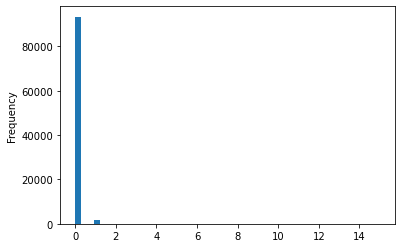

In [273]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

# Frequency/Recency Analysis Using the BG/NBD Model

In [274]:
bgf = BetaGeoFitter()
bgf.fit(data["frequency"],
        data["recency"], 
        data["T"], 
        iterative_fitting = 3, 
        verbose = True)

Optimization terminated successfully.
         Current function value: 0.083559
         Iterations: 65
         Function evaluations: 67
         Gradient evaluations: 67


<lifetimes.BetaGeoFitter: fitted with 95420 subjects, a: 3.29, alpha: 29.53, b: 0.40, r: 0.01>

### Visualizing our frequency/recency matrix

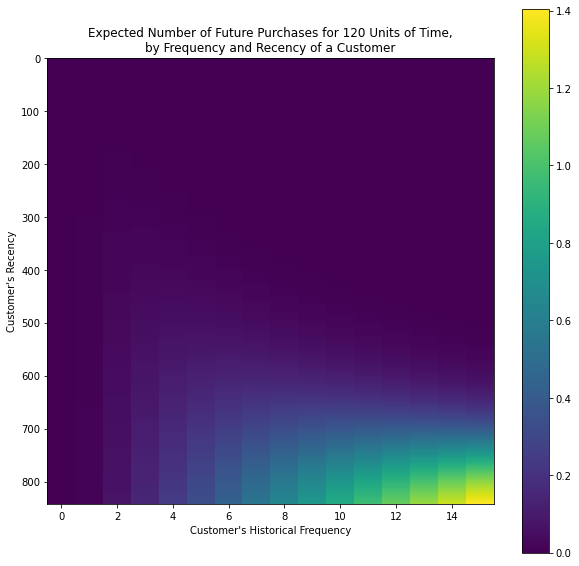

In [275]:
plt.figure(figsize=(10, 10))
plot_frequency_recency_matrix(bgf, T=120);
plt.savefig('/Users/tejaltandel/archive/freqrecency.png',transparent=True)

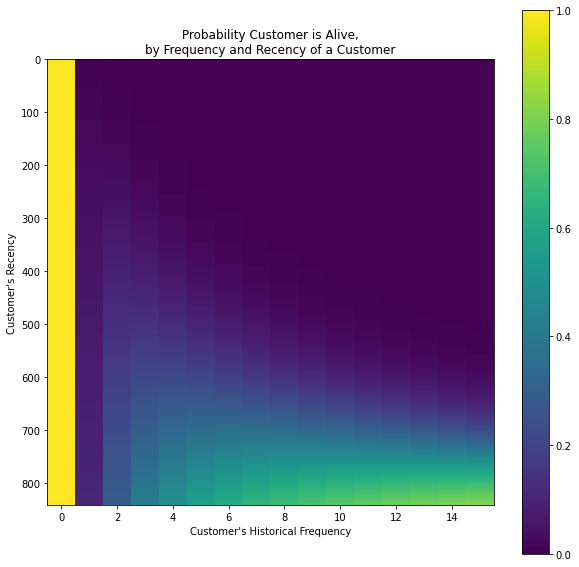

In [276]:
plt.figure(figsize=(10, 10))
plot_probability_alive_matrix(bgf);

In [277]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
customer_id,,,,,
083ca1aa470c280236380973a48f77c6,3.0,381.0,515.0,66.326667,0.001310
7305430719d715992b00be82af4a6aa8,3.0,400.0,531.0,53.100000,0.001321
394ac4de8f3acb14253c177f0e15bc58,4.0,236.0,368.0,123.400000,0.001710
dc813062e0fc23409cd255f7f53c7074,5.0,418.0,542.0,97.552000,0.002466
8d50f5eadf50201ccdcedfb9e2ac8455,15.0,462.0,589.0,47.642000,0.002954


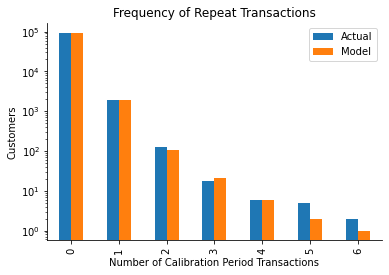

In [278]:
ax = plot_period_transactions(bgf, max_frequency=7)
ax.set_yscale('log')
sns.despine();

In [279]:
cal_hold = calibration_and_holdout_data(purchases_db, 
                                        customer_id_col = 'customer_id',
                                        datetime_col = 'order_date',
                                        freq = 'D',
                                        calibration_period_end = '2018-06-30',
                                        observation_period_end = '2018-09-28',
                                        monetary_value_col = 'total_cost' )
print(cal_hold.head())

                                  frequency_cal  recency_cal  T_cal  \
customer_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2            0.0          0.0   51.0   
0000b849f77a49e4a4ce2b2a4ca5be3f            0.0          0.0   54.0   
0000f46a3911fa3c0805444483337064            0.0          0.0  477.0   
0000f6ccb0745a6a4b88665a16c9f078            0.0          0.0  261.0   
0004aac84e0df4da2b147fca70cf8255            0.0          0.0  228.0   

                                  monetary_value_cal  frequency_holdout  \
customer_id                                                               
0000366f3b9a7992bf8c76cfdf3221e2                 0.0                0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                 0.0                0.0   
0000f46a3911fa3c0805444483337064                 0.0                0.0   
0000f6ccb0745a6a4b88665a16c9f078                 0.0                0.0   
0004aac84e0df4da2b147fca70cf8255                 0.0

In [280]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter()
bgf.fit(cal_hold["frequency_cal"], 
        cal_hold["recency_cal"], 
        cal_hold["T_cal"], 
        iterative_fitting = 3, 
        verbose = True)

Optimization terminated successfully.
         Current function value: 0.078588
         Iterations: 58
         Function evaluations: 61
         Gradient evaluations: 61


<lifetimes.BetaGeoFitter: fitted with 83128 subjects, a: 1.65, alpha: 71.15, b: 0.30, r: 0.02>

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

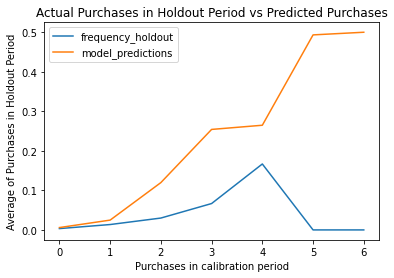

In [281]:
bgf.fit(cal_hold['frequency_cal'], cal_hold['recency_cal'], cal_hold['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, cal_hold)

In [282]:
t = 120
predicted_purchases = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                               cal_hold['frequency_cal'], 
                                                                               cal_hold['recency_cal'],
                                                                               cal_hold['T_cal'])
predicted_purchases.sort_values().tail(4)

customer_id
fe81bb32c243a86b2f86fbf053fe6140    0.765942
6469f99c1f9dfae7733b25662e7f1782    0.983676
ca77025e7201e3b30c44b472ff346268    1.117771
8d50f5eadf50201ccdcedfb9e2ac8455    1.488107
dtype: float64

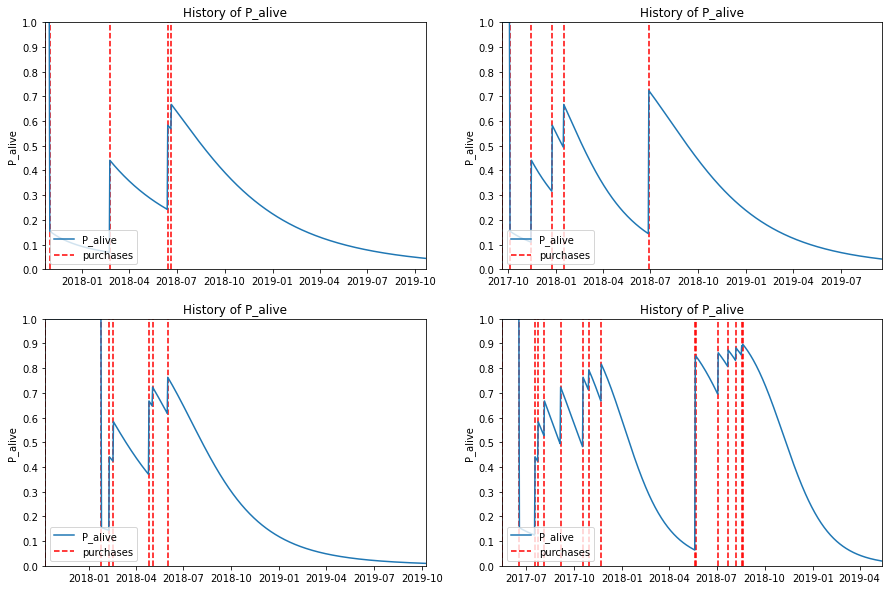

In [283]:
fig = plt.figure(figsize=(15, 10))
t = max(purchases_db.order_date - min(purchases_db.order_date))
for idx, customer_id in enumerate(predicted_purchases.sort_values().tail(4).index, 1):
    days_since_birth = (t).days
    sp_trans = purchases_db.loc[purchases_db['customer_id'] == customer_id]
    
    plot_history_alive(bgf, days_since_birth, sp_trans, 'order_date', ax=fig.add_subplot(2, 2, idx))
    
fig.savefig('/Users/tejaltandel/archive/palive.png',transparent=True)

In [284]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))
print(returning_customers_summary[["frequency", "monetary_value"]].corr())

                                  frequency  recency      T  monetary_value  \
customer_id                                                                   
004288347e5e88a27ded2bb23747066c        1.0    171.0  516.0           87.90   
004b45ec5c64187465168251cd1c9c2f        1.0    267.0  480.0           27.00   
0058f300f57d7b93c477a131a59b36c3        1.0     31.0  309.0           72.58   
00a39521eb40f7012db50455bf083460        1.0     11.0  216.0           11.55   
011575986092c30523ecb71ff10cb473        1.0     60.0  311.0           63.90   

                                  predicted_purchases  
customer_id                                            
004288347e5e88a27ded2bb23747066c             0.000078  
004b45ec5c64187465168251cd1c9c2f             0.000129  
0058f300f57d7b93c477a131a59b36c3             0.000062  
00a39521eb40f7012db50455bf083460             0.000079  
011575986092c30523ecb71ff10cb473             0.000090  
2085
                frequency  monetary_value
frequen

<AxesSubplot:xlabel='$log(monetary\\_value)$', ylabel='Density'>

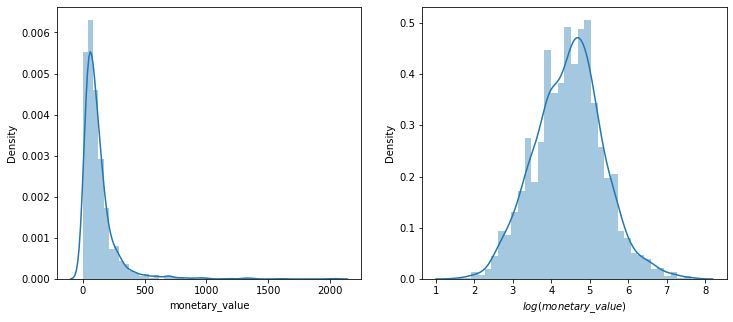

In [285]:
fig, axes = plt.subplots(1,2,figsize=(12, 5))
sns.distplot(returning_customers_summary["monetary_value"], ax=axes[0], )
sns.distplot(np.log(returning_customers_summary["monetary_value"] + 1), ax=axes[1], axlabel='$log(monetary\_value)$')

In [286]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter()
ggf.fit(returning_customers_summary["frequency"], 
       returning_customers_summary["monetary_value"], verbose=True)

Optimization terminated successfully.
         Current function value: 5.753528
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27


<lifetimes.GammaGammaFitter: fitted with 2085 subjects, p: 2.81, q: 2.94, v: 88.94>

In [287]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(5))

customer_id
0000366f3b9a7992bf8c76cfdf3221e2    129.181956
0000b849f77a49e4a4ce2b2a4ca5be3f    129.181956
0000f46a3911fa3c0805444483337064    129.181956
0000f6ccb0745a6a4b88665a16c9f078    129.181956
0004aac84e0df4da2b147fca70cf8255    129.181956
dtype: float64


In [288]:
pp =ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    )

### After applying Gamma-Gamma model, now we can estimate average transaction value for each customer

In [289]:
df = pd.DataFrame(pp).reset_index()
df.columns = ['customer_id','value']
df

,customer_id,value
0,0000366f3b9a7992bf8c76cfdf3221e2,129.181956
1,0000b849f77a49e4a4ce2b2a4ca5be3f,129.181956
2,0000f46a3911fa3c0805444483337064,129.181956
3,0000f6ccb0745a6a4b88665a16c9f078,129.181956
4,0004aac84e0df4da2b147fca70cf8255,129.181956
...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,129.181956
95416,fffea47cd6d3cc0a88bd621562a9d061,129.181956
95417,ffff371b4d645b6ecea244b27531430a,129.181956
95418,ffff5962728ec6157033ef9805bacc48,129.181956


In [290]:
df.to_csv('/Users/tejaltandel/archive/testltv.csv')

In [291]:
df['value'].nunique()

1043

# CONCLUSION

### Therefore, we analyzed statistics like new customers, old customers, retention rate and the associated sales. These metrics will help the stakeholder dashboard